In [1]:
# Imports
from data_loader import (
    load_syllable_data,
    load_tracking_data,
    load_fiber_data,
    align_and_merge_data
)
from data_processing import (
    compute_syllable_counts,
    rank_syllables,
    extract_signal_snippets
)
from plotting import plot_syllable_signal
from analysis import (
    load_behavior_distances,
    compute_photometry_distance_matrix,
    compare_distance_matrices
)

In [2]:
# Parameters
file_suffix = '56234'
file_path = f'../soeren_syllable_data/results_h5/results_kappa_scan_{file_suffix}.h5'
mouse_ids = list(range(16, 23))
include_latent_state = True
tracking_prefix_func = lambda s: f'../soeren_syllable_data/TrackingData_mus{s}.csv'
fiber_prefix_func = lambda s: f'../soeren_syllable_data/sig_data_with_Scaled_zDFF_mus{s}.csv'
parameters = {
    'm': 150,
    'n': 150,
    'normalization_frame': 0,
    'window_size': 15,
    'min_snippets_required': 10,
    # Add other parameters as needed
}
save_figs = False

In [3]:
# Data Loading and Preprocessing
syllable_dfs = load_syllable_data(file_path, include_latent_state)
tracking_dfs = load_tracking_data(mouse_ids, tracking_prefix_func)
fiber_dfs = load_fiber_data(mouse_ids, fiber_prefix_func)
merged_dfs = align_and_merge_data(syllable_dfs, tracking_dfs, fiber_dfs)

In [4]:
def cluster_syllables(
    coordinates,
    results,
    n_clusters,
    metric="cosine",
    pre=5,
    post=15,
    min_frequency=0.005,
    min_duration=3,
    bodyparts=None,
    use_bodyparts=None,
    density_sample=False,
    sampling_options={"n_neighbors": 50},
):
    """
    Cluster syllables into n groups based on their typical trajectories.

    Parameters
    ----------
    coordinates : dict
        Dictionary mapping recording names to keypoint coordinates as
        ndarrays of shape (n_frames, n_bodyparts, [2 or 3]).

    results : dict
        Dictionary containing modeling results for a dataset.

    n_clusters : int
        The number of clusters to form.

    metric : str, default='cosine'
        Distance metric to use. See :py:func:`scipy.spatial.distance.pdist` for options.

    Other parameters are the same as in keypoint_moseq.util.get_typical_trajectories.

    Returns
    -------
    syllable_clusters : dict
        Dictionary mapping syllable indices to cluster labels.
    """
    import numpy as np
    from sklearn.cluster import KMeans
    import keypoint_moseq as kpms

    # Get the typical trajectories
    typical_trajects = kpms.util.get_typical_trajectories(
        coordinates,
        results,
        pre=pre,
        post=post,
        min_frequency=min_frequency,
        min_duration=min_duration,
        bodyparts=bodyparts,
        use_bodyparts=use_bodyparts,
        density_sample=density_sample,
        sampling_options=sampling_options,
    )

    # Create a list of syllable indices
    syllable_ixs = sorted(typical_trajects.keys())

    # Initialize a list to hold feature vectors
    features = []

    for s in syllable_ixs:
        traj = typical_trajects[s]  # shape (pre+post, n_bodyparts, [2 or 3])
        # Flatten the trajectory
        feat = traj.flatten()
        features.append(feat)

    # Stack the features into a matrix
    X = np.vstack(features)  # shape (n_syllables, n_features)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    # Get the cluster labels
    labels = kmeans.labels_  # array of length n_syllables

    # Map syllable indices to cluster labels
    syllable_clusters = {s: l for s, l in zip(syllable_ixs, labels)}

    return syllable_clusters

In [5]:
import keypoint_moseq as kpms

In [6]:
res1 = kpms.io.load_results(path='/Users/fsp585/Desktop/GetherLabCode/Openfield/soeren_syllable_data/results_h5/results_kappa_scan_56234.h5')

In [7]:
dlc_path = '/Users/fsp585/Desktop/GetherLabCode/Openfield/soeren_syllable_data/T*DLC.csv'
coordinates, confidences, bodyparts = kpms.load_keypoints(dlc_path, 'deeplabcut')

Loading keypoints: 100%|██████████████████| 7/7 [00:07<00:00,  1.13s/it]


In [10]:
coordinates['T21_m435_2020-05-06T10_52_46DLC'].shape

(347021, 10, 2)

In [12]:
confidences['T21_m435_2020-05-06T10_52_46DLC'].shape

(347021, 10)

In [13]:
bodyparts

['snout',
 'mouth',
 'throat',
 'stomach',
 'genitals',
 'tailbase',
 'frontPawRight',
 'frontPawLeft',
 'backPawRight',
 'backPawLeft']

In [12]:
typical_trajects = kpms.util.get_typical_trajectories(coordinates, res1)

In [13]:
# Assuming you have 'coordinates' and 'results' already defined
n_clusters = 7  # Set the number of clusters you want
syllable_clusters = cluster_syllables(coordinates, res1, n_clusters)

# Now 'syllable_clusters' is a dictionary mapping syllable indices to cluster labels
print(syllable_clusters)

{0: 1, 1: 1, 2: 2, 3: 2, 4: 1, 5: 5, 6: 2, 7: 1, 8: 2, 9: 5, 10: 1, 11: 0, 12: 4, 13: 0, 14: 2, 15: 5, 16: 1, 17: 4, 18: 2, 19: 0, 20: 1, 21: 4, 22: 2, 23: 3, 24: 5, 25: 1, 26: 4, 27: 0, 28: 0, 29: 2, 30: 1, 31: 1, 32: 1, 33: 6, 34: 3, 35: 1, 36: 3, 37: 2, 38: 5, 39: 1, 40: 6, 41: 3, 42: 3, 43: 3, 44: 6, 45: 6, 46: 3, 47: 6, 48: 3, 49: 0}


In [14]:
for k in merged_dfs.keys():
    merged_dfs[k]['syllable_0'] = merged_dfs[k]['syllable_0'].apply(lambda x: syllable_clusters.get(x, -1))

In [15]:
# Data Analysis
syllable_snippets_DS, syllable_snippets_VS = extract_signal_snippets(merged_dfs, parameters)

In [16]:
import importlib
import plotting  # Replace with your actual module name

# Force reload
importlib.reload(plotting)


<module 'plotting' from '/Users/fsp585/Desktop/GetherLabCode/Openfield/syllable_root/plotting.py'>

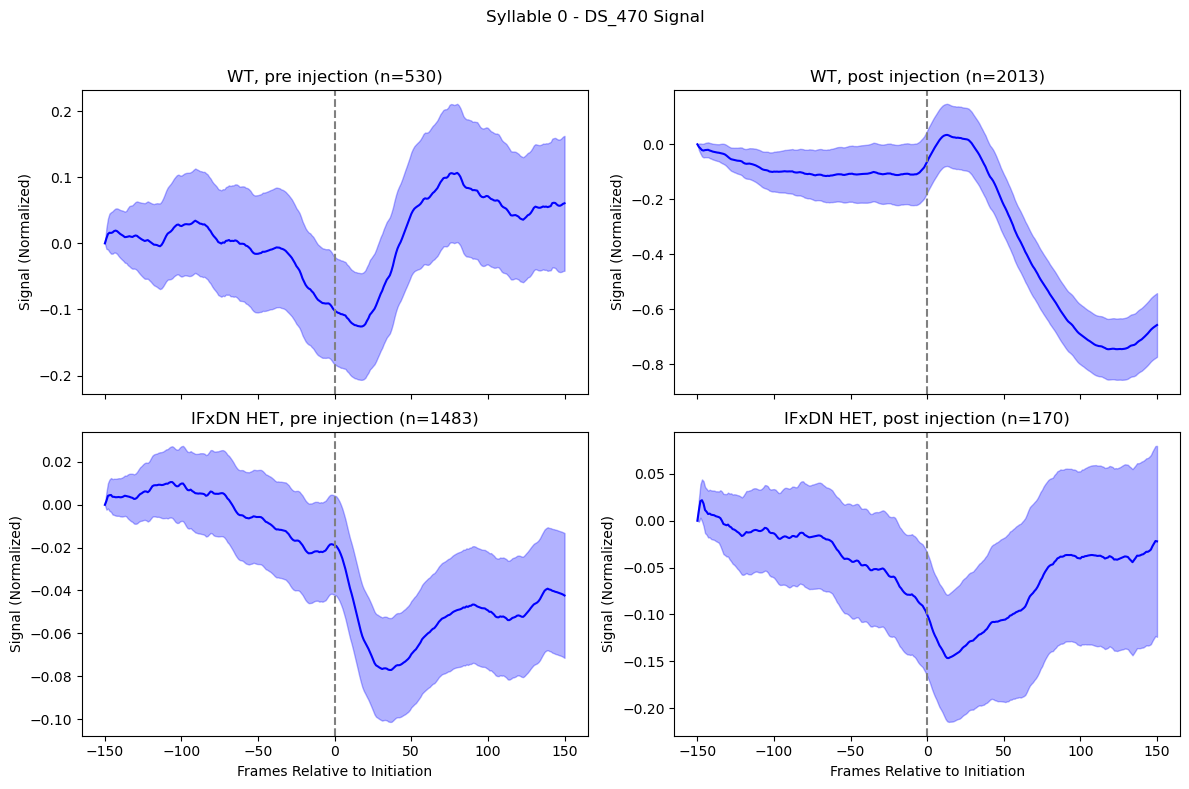

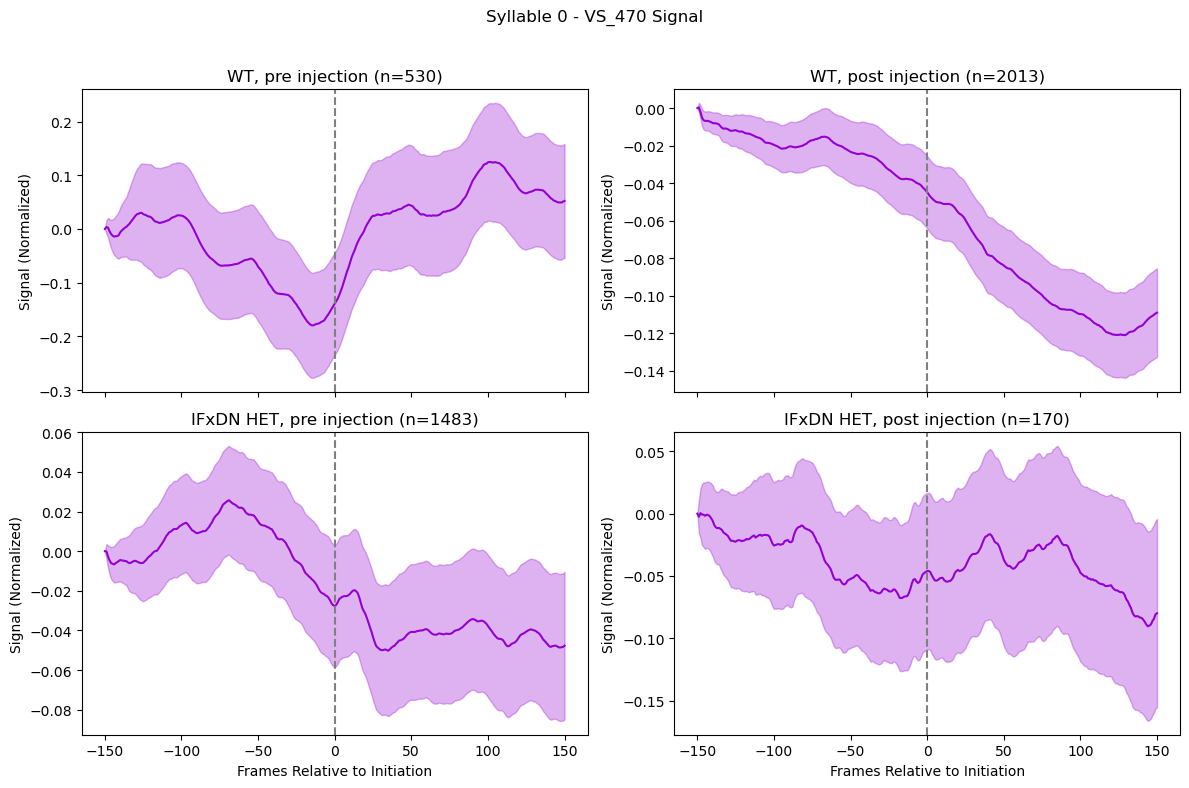

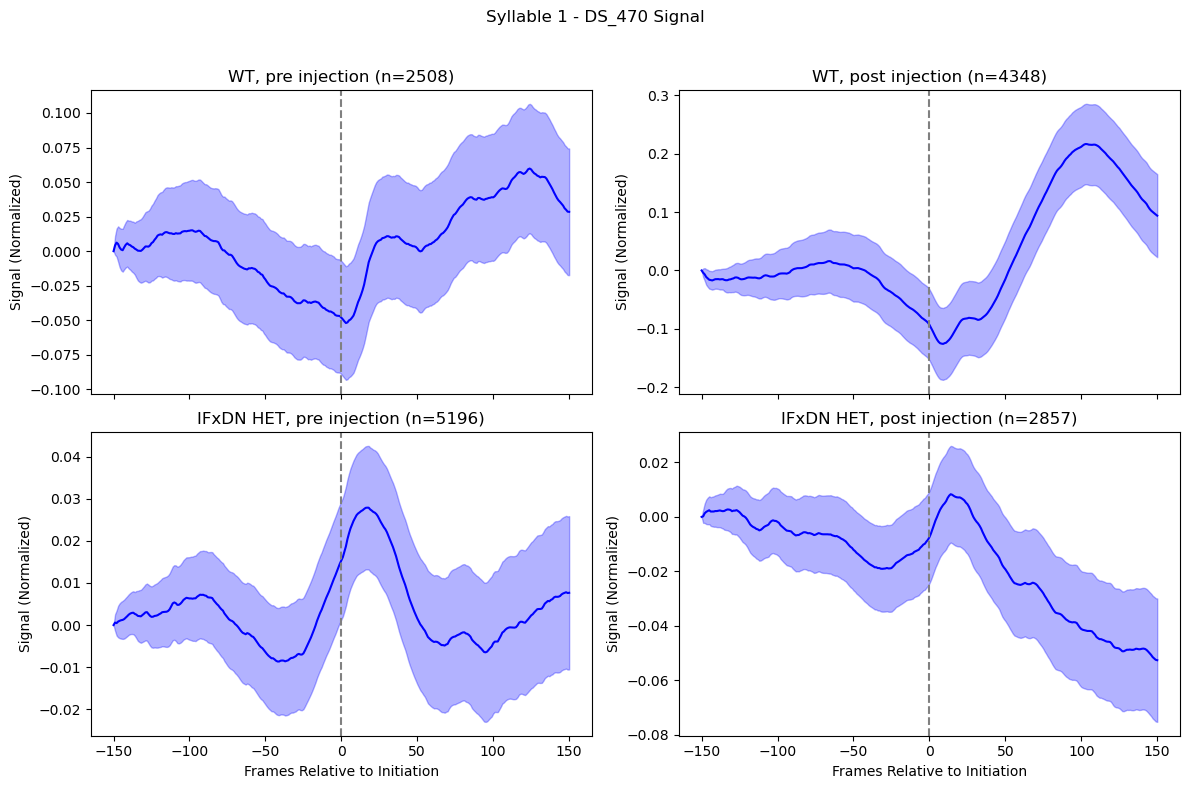

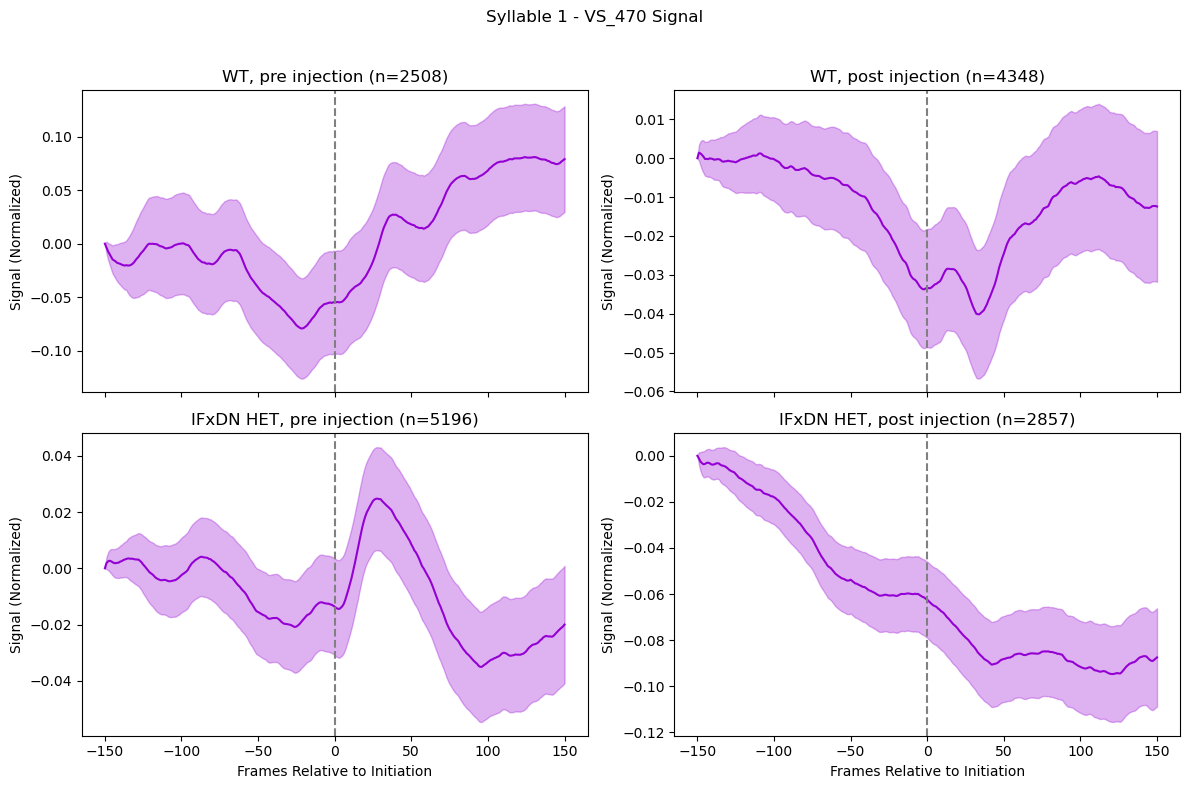

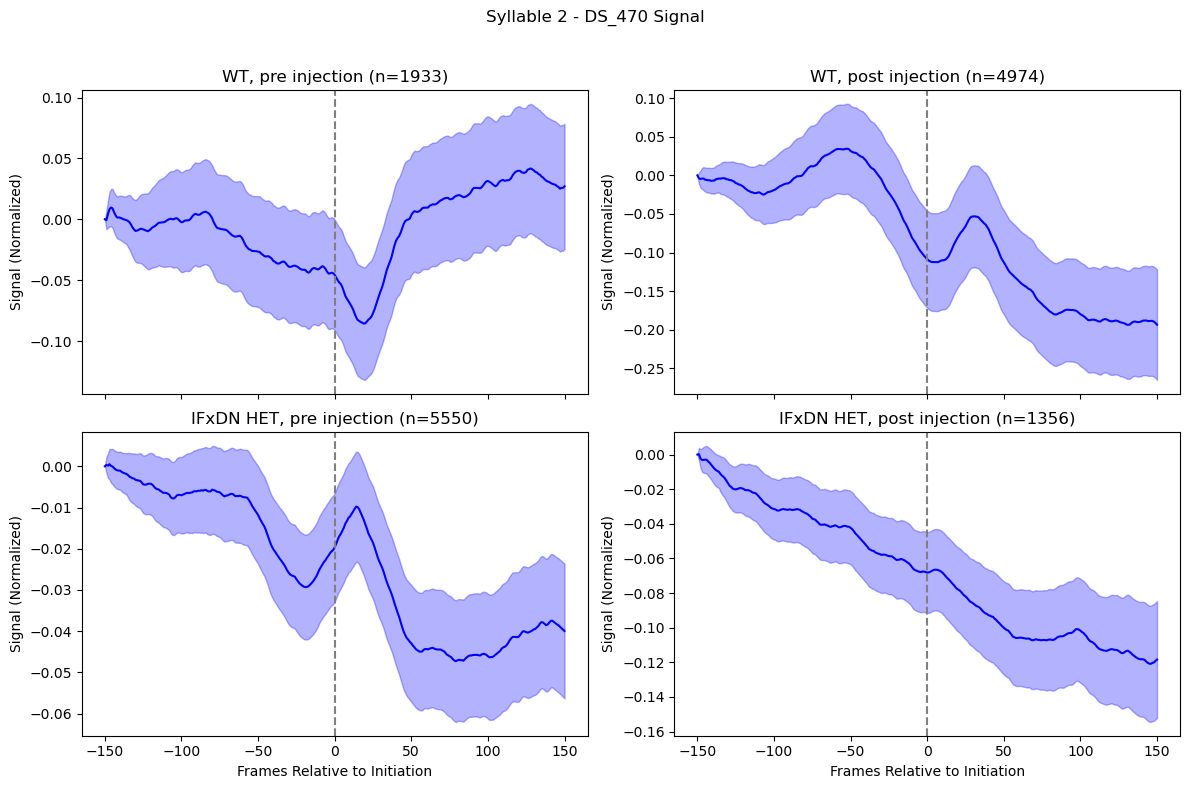

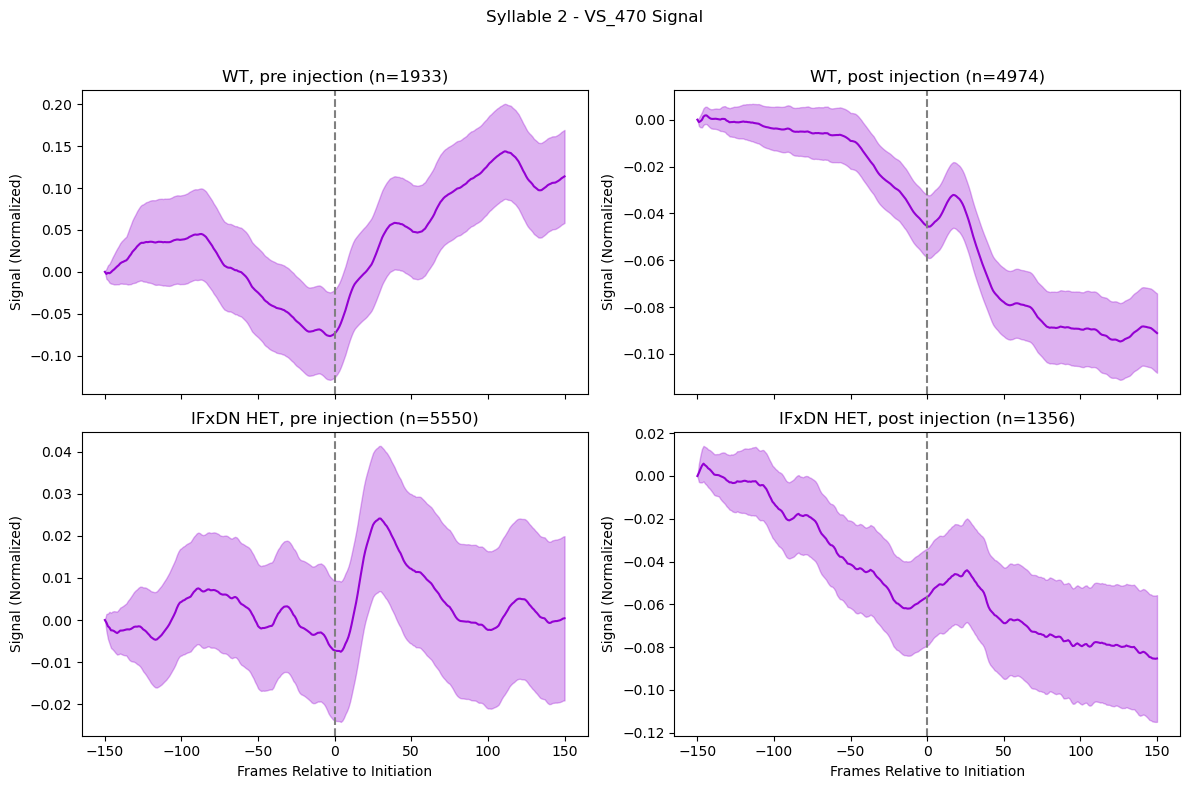

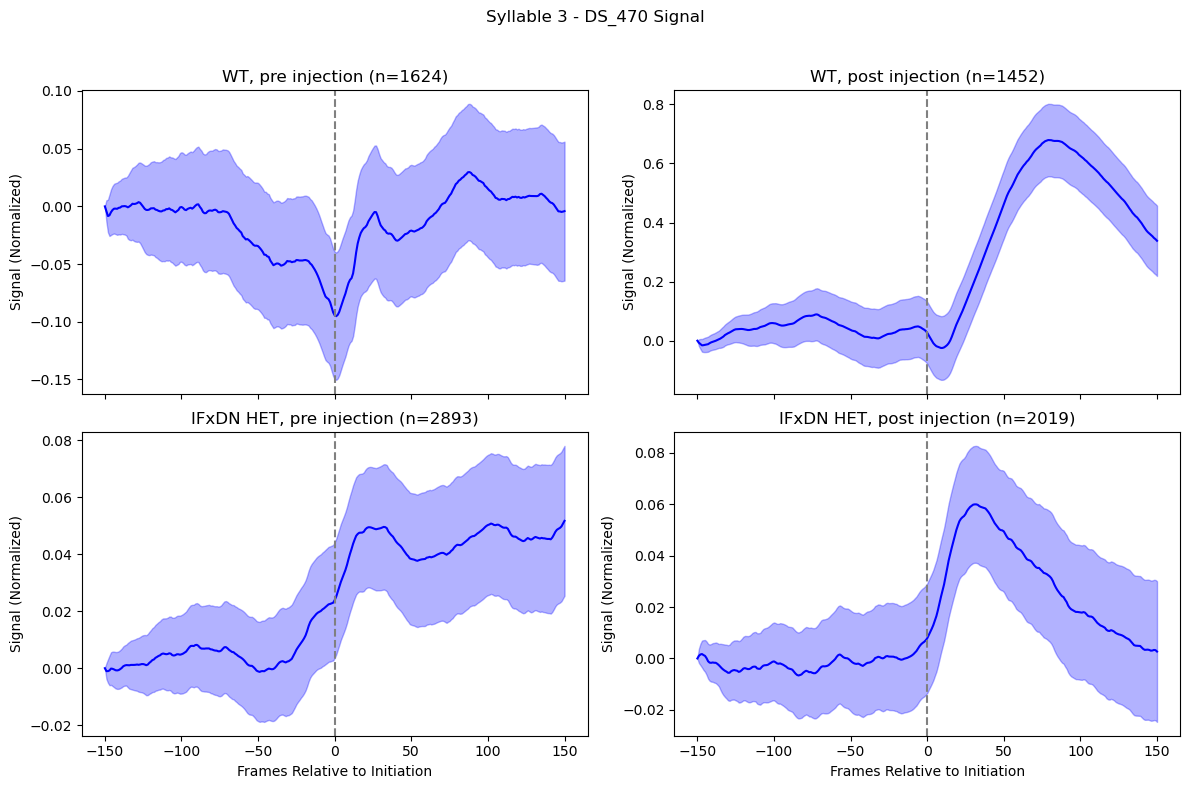

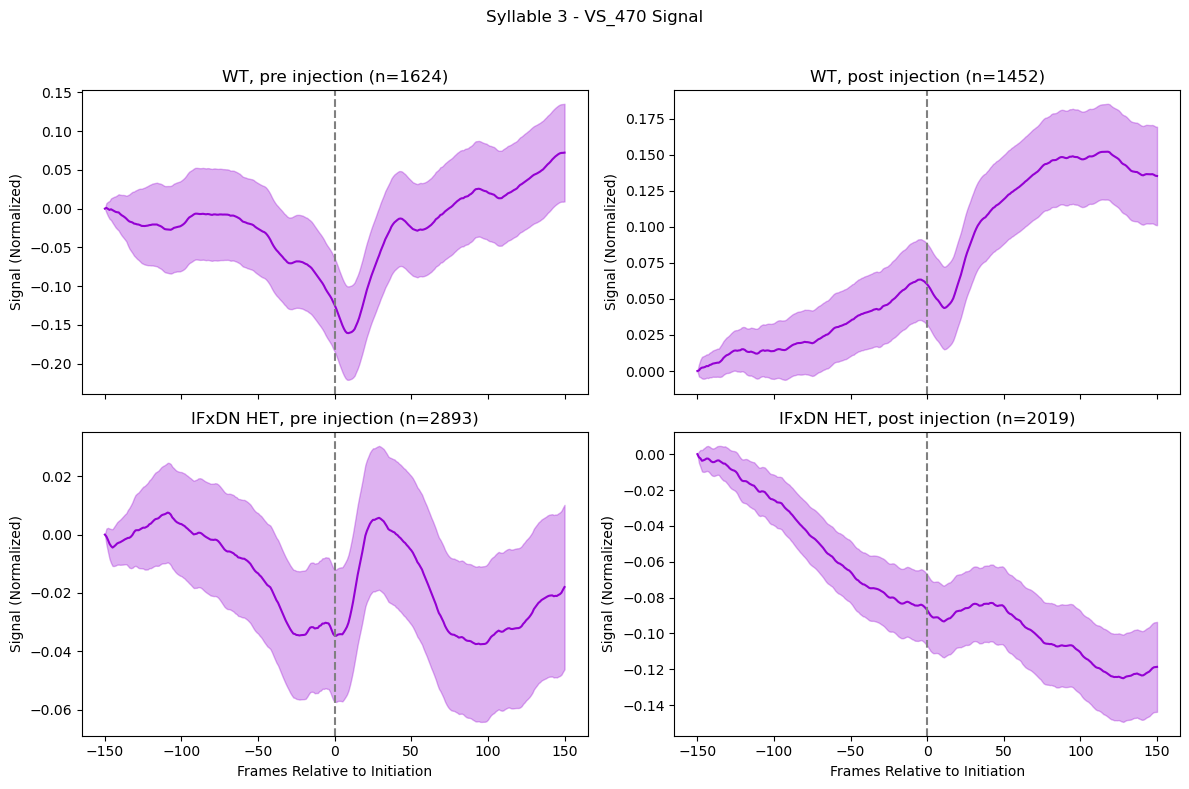

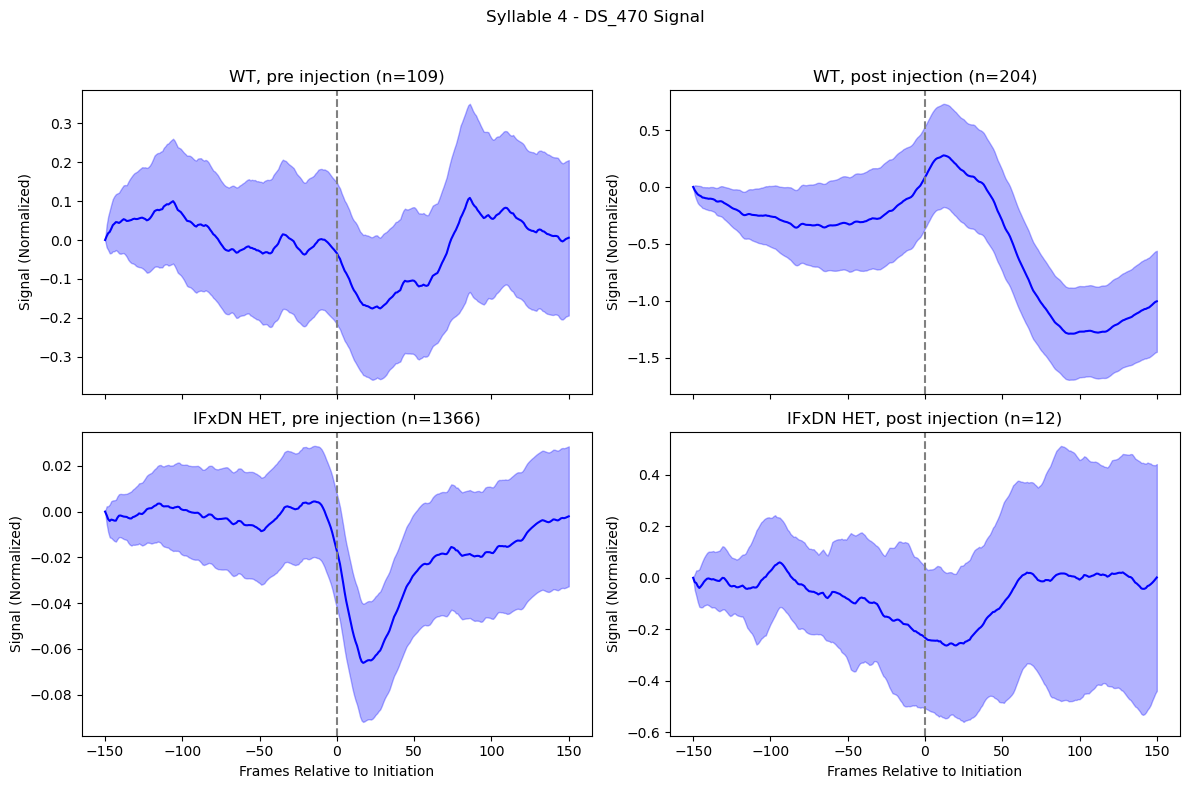

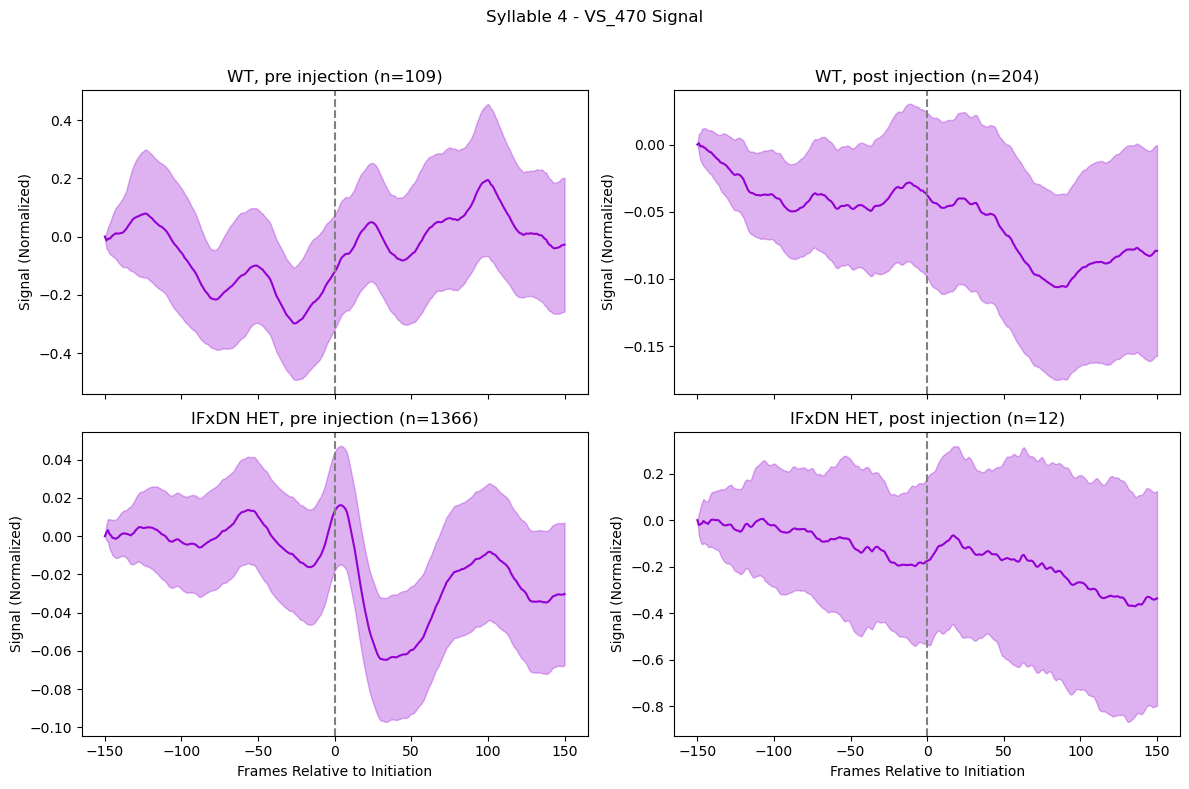

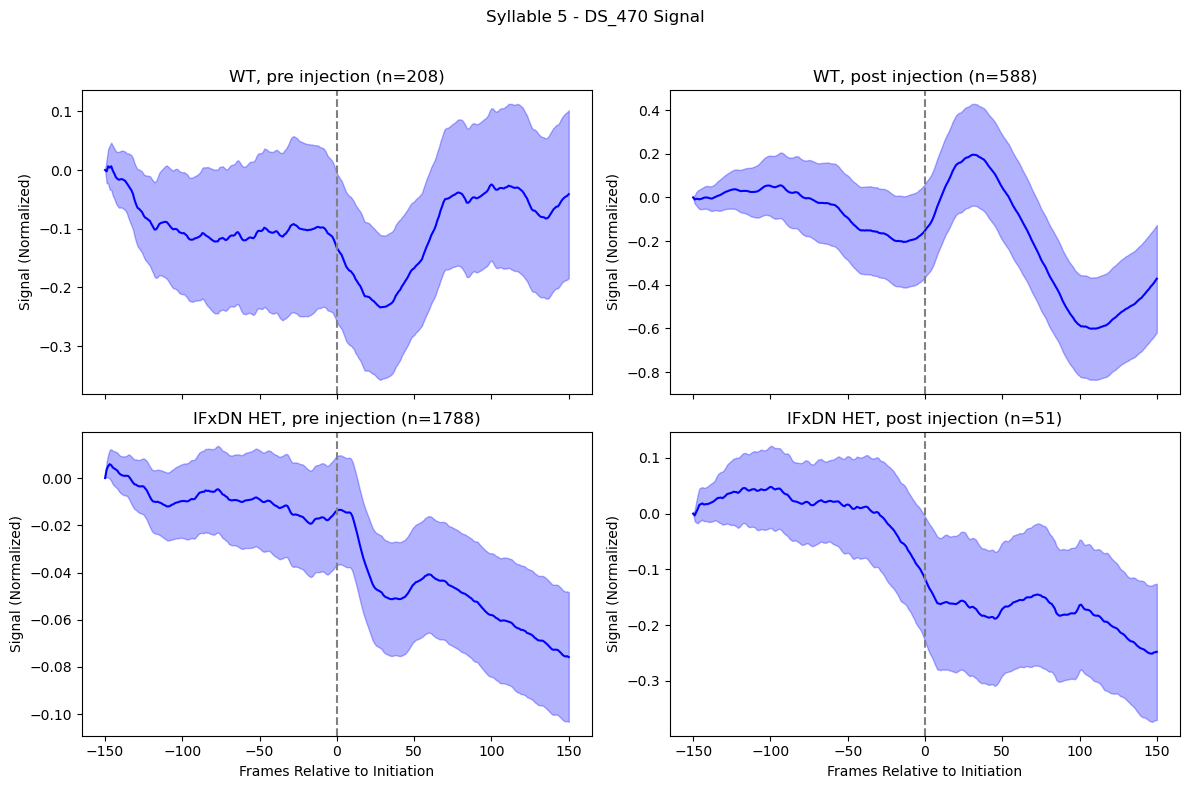

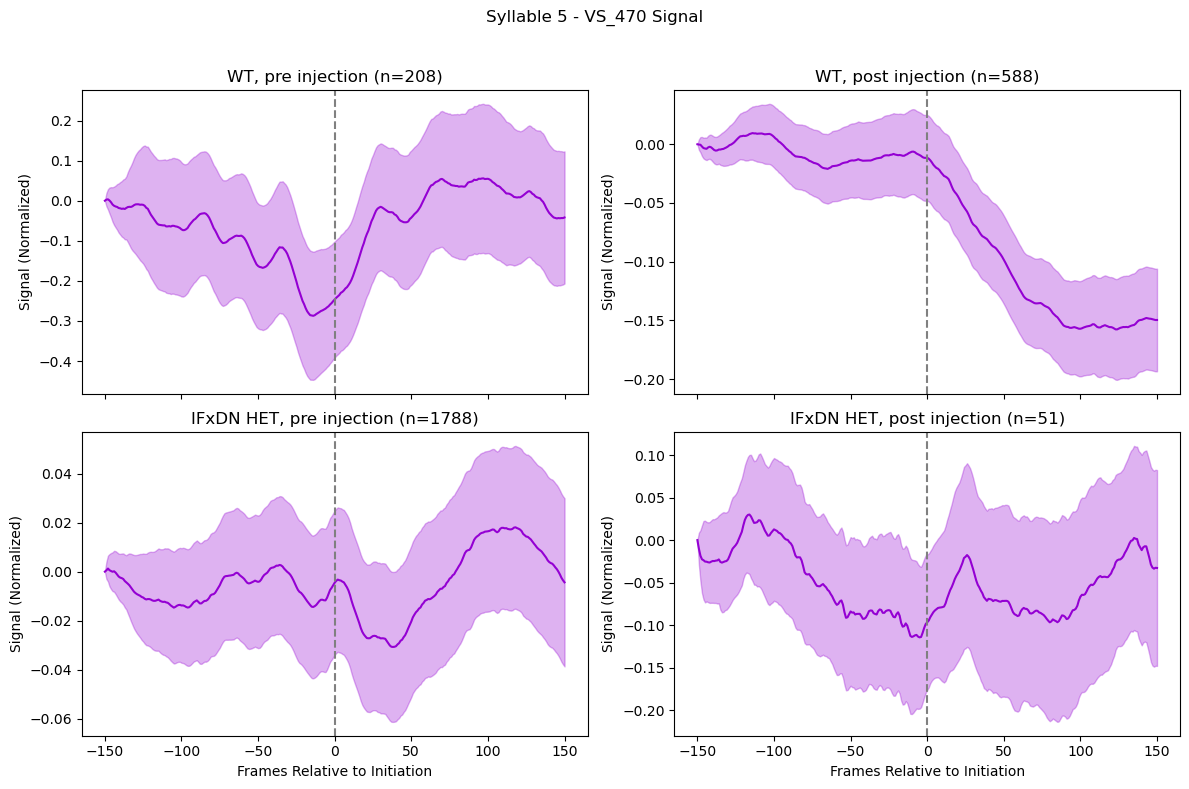

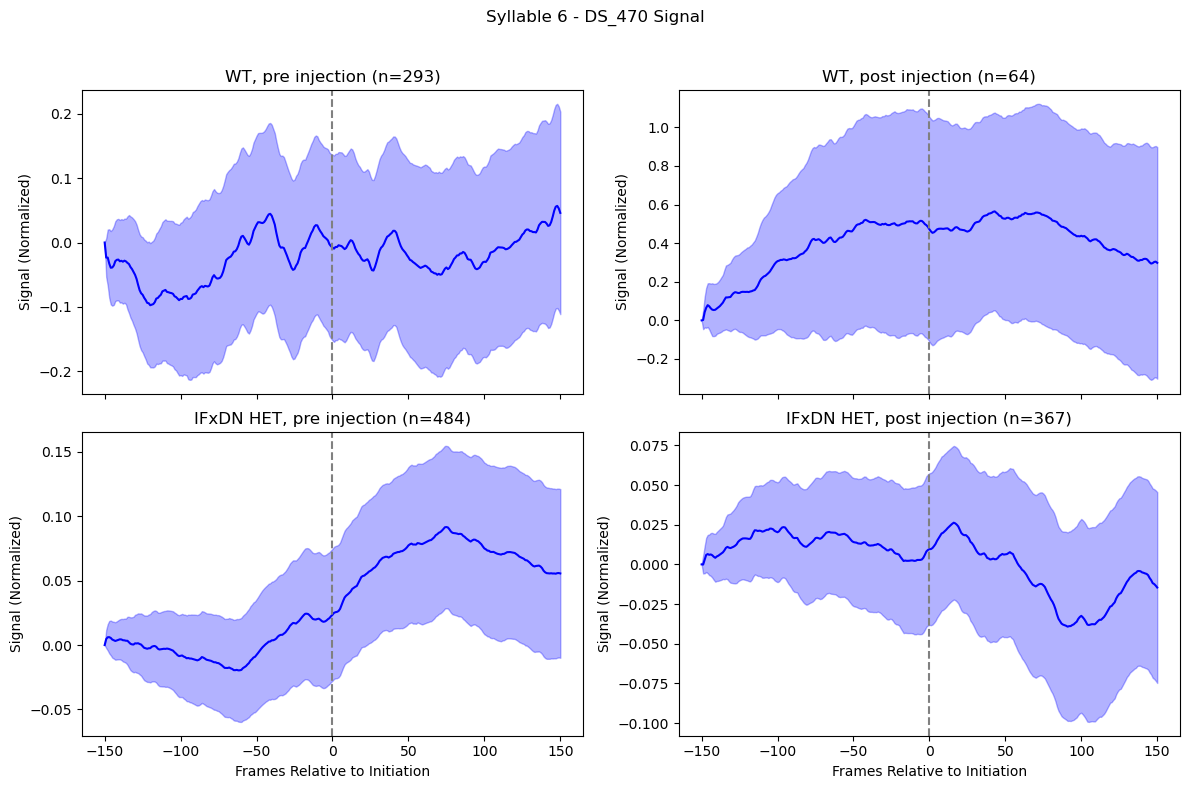

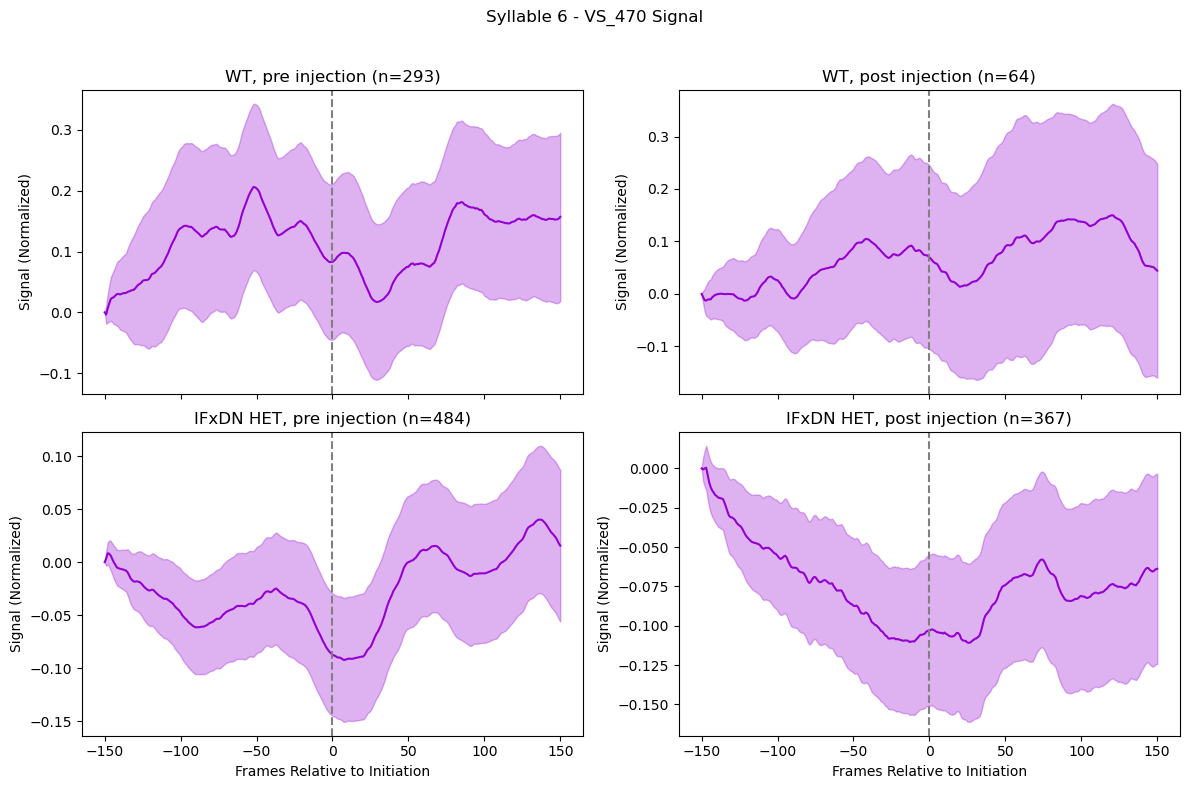

In [17]:
for syllable in range(max(syllable_clusters.values()) + 1):  # Top 30 syllables
    plotting.plot_syllable_signal(syllable, 'DS', syllable_snippets_DS, save_figs=save_figs)
    plotting.plot_syllable_signal(syllable, 'VS', syllable_snippets_VS, save_figs=save_figs)

In [18]:
from collections import defaultdict
cluster_lists = defaultdict(list)

for k, v in syllable_clusters.items():
    cluster_lists[v].append(k)

for k, v in cluster_lists.items():
    print(k, v)

1 [0, 1, 4, 7, 10, 16, 20, 25, 30, 31, 32, 35, 39]
2 [2, 3, 6, 8, 14, 18, 22, 29, 37]
5 [5, 9, 15, 24, 38]
0 [11, 13, 19, 27, 28, 49]
4 [12, 17, 21, 26]
3 [23, 34, 36, 41, 42, 43, 46, 48]
6 [33, 40, 44, 45, 47]


Saving trajectory plots to traj_out


Generating trajectory plots: 100%|██████| 50/50 [00:14<00:00,  3.52it/s]


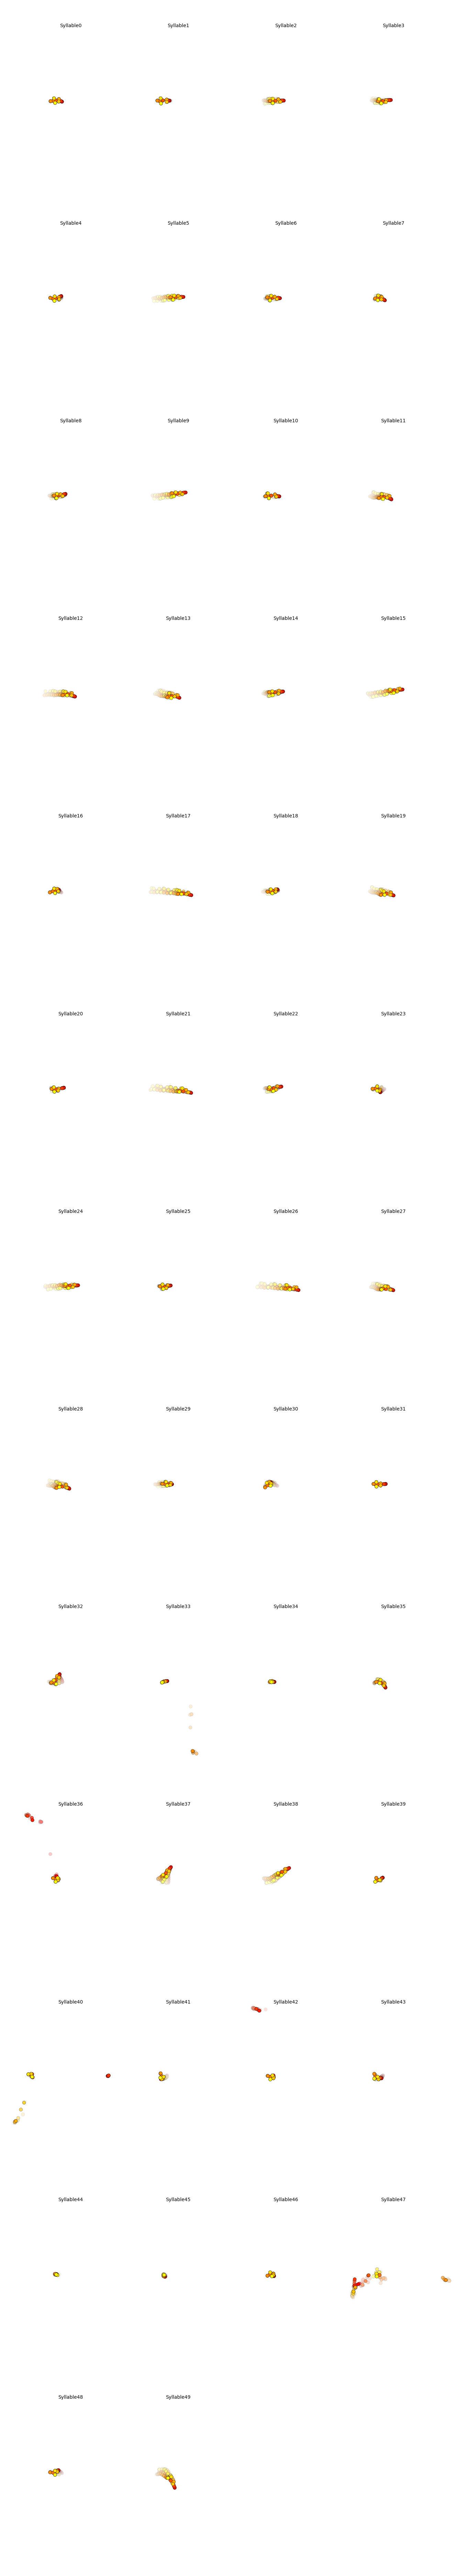

In [19]:
kpms.viz.generate_trajectory_plots(coordinates, res1, output_dir='traj_out')

In [20]:


syllable_clusters

{0: 1,
 1: 1,
 2: 2,
 3: 2,
 4: 1,
 5: 5,
 6: 2,
 7: 1,
 8: 2,
 9: 5,
 10: 1,
 11: 0,
 12: 4,
 13: 0,
 14: 2,
 15: 5,
 16: 1,
 17: 4,
 18: 2,
 19: 0,
 20: 1,
 21: 4,
 22: 2,
 23: 3,
 24: 5,
 25: 1,
 26: 4,
 27: 0,
 28: 0,
 29: 2,
 30: 1,
 31: 1,
 32: 1,
 33: 6,
 34: 3,
 35: 1,
 36: 3,
 37: 2,
 38: 5,
 39: 1,
 40: 6,
 41: 3,
 42: 3,
 43: 3,
 44: 6,
 45: 6,
 46: 3,
 47: 6,
 48: 3,
 49: 0}